# Efficient Frontier Example

This notebook shows a simple code to implement **python technique** for efficient fromtier calculation due to Harry Markowitz . 
- Run the cell below to import some libraries and functions to plot them

In [29]:
import numpy as np
import pandas as pd
import pandas_datareader
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import ipywidgets as widgets

%matplotlib inline

df = pandas_datareader.get_data_yahoo(["AAPL", "IBM", "AMZN"], start='2010-01-01', end="2020-10-18", interval='m')
monthly_r = ((df["Adj Close"] - df["Adj Close"].shift(1))/df["Adj Close"].shift(1)).dropna()[:-1]
expected_return = monthly_r.mean()
expected_volatility = monthly_r.std()
cov_mtx = pd.DataFrame.corr(monthly_r)

def plot_2_assest_example(rho=0):
    
    r_1, r_2, v_1, v_2 = 0.1, 0.3, 0.25, 0.2
    r = [portfolio_r(w, r_1, r_2)      for w in np.linspace(0,1,100)]
    v = [portfolio_v(w, v_1, v_2, rho) for w in np.linspace(0,1,100)]

    plt.figure(figsize=(12,6))
    plt.scatter(r_1, v_1, label="company-1", s=150)
    plt.scatter(r_2, v_2, label="company-2", s=150)
    plt.plot(r, v, label=r"$\rho= $"+ str(rho))
    
    plt.legend(fontsize=15)
    plt.grid()
    plt.xlabel("expected return", fontsize=15)
    plt.ylabel("volatility", fontsize=15)
    plt.ylim(0.15, 0.26)

def run_plot_2_assest_example():
    plot_2_example_toy = widgets.interactive(plot_2_assest_example, 
                                             rho=widgets.FloatSlider(min=0,max=1,step=0.05,value=0), 
                                            )
    display(plot_2_example_toy)

def loss(weights, volatility, cov_mtx):
    return ((weights*volatility).T @ cov_mtx @ (weights*volatility))**0.5

def ef(target_return, expected_return, volatility, cov_mtx):
    
    n = expected_return.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0), )*n
    
    return_is_target = {
        "type" : "eq",
        "args" : (expected_return, ),
        "fun": lambda weights, er: target_return - weights.T @ er
    }

    weights_sum_to_1 = {
        "type" : "eq",
        "fun" : lambda weights: np.sum(weights) - 1
    }

    results = minimize(loss, init_guess, 
                       args=(volatility, cov_mtx, ), method="SLSQP", 
                       options={"disp": False}, constraints=(return_is_target, weights_sum_to_1),
                       bounds=bounds)
    
    return results.x

- Run the cell below to see a simple illustration of correlation's dependency on (vol, return)

In [25]:
w = np.linspace(0,1,100)
portfolio_r = lambda w, r_1, r_2: w*r_1 + (1-w)*r_2
portfolio_v = lambda w, v_1, v_2, rho: np.sqrt( (w*v_1)**2. + ((1-w)*v_2)**2. + 2*(v_1*w*v_2*(1-w)*rho) )
optimal_w  = lambda s_1, s_2, rho: (2*s_1**2 - 2*s_1*s_2*rho)/(2*s_1**2 + 2*s_2**2 - 4*s_1*s_2*rho)

run_plot_2_assest_example()

interactive(children=(FloatSlider(value=0.0, description='rho', max=1.0, step=0.05), Output()), _dom_classes=(…

- Below plot a 2-assets scenario (APPL & IBM)

Text(0, 0.5, 'expected volatility')

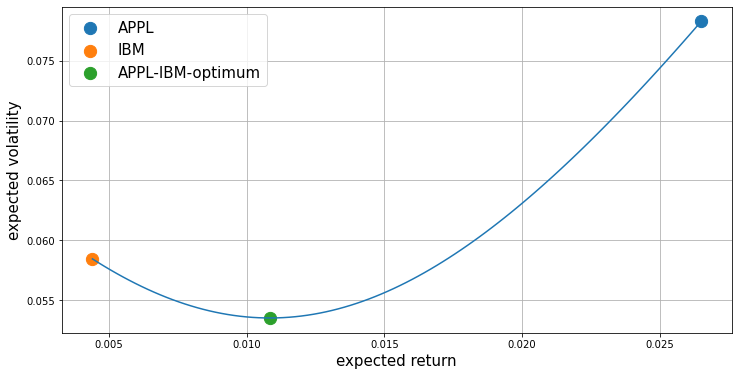

In [27]:
w_star = optimal_w(expected_volatility["IBM"], expected_volatility["AAPL"], cov_mtx["AAPL"]["IBM"])

plt.figure(figsize=(12,6))
plt.scatter(expected_return["AAPL"], expected_volatility["AAPL"], label="APPL", s=150)
plt.scatter(expected_return["IBM"],  expected_volatility["IBM"],  label="IBM", s=150)

plt.plot(portfolio_r(w, expected_return["AAPL"], expected_return["IBM"]), 
         portfolio_v(w, expected_volatility["AAPL"], expected_volatility["IBM"], cov_mtx["AAPL"]["IBM"]))

plt.scatter(portfolio_r(w_star, expected_return["AAPL"], expected_return["IBM"]),  
            portfolio_v(w_star, expected_volatility["AAPL"], expected_volatility["IBM"], cov_mtx["AAPL"]["IBM"]),
            label="APPL-IBM-optimum", s=150)


plt.legend(fontsize=15)
plt.grid()
plt.xlabel("expected return", fontsize=15)
plt.ylabel("expected volatility", fontsize=15)

# N assests portfolio optimization
- Run the cell below to see the efficient frontier on three-assets scenario (APPL & IBM & AMZN).

Text(0, 0.5, 'expected volatility')

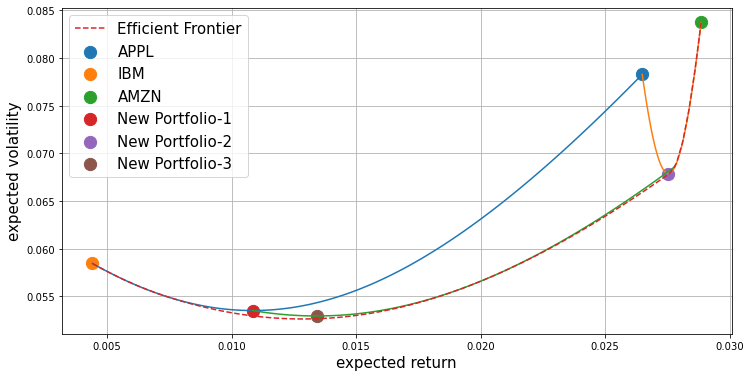

In [30]:
s = []
r = []
for target in np.linspace(monthly_r.mean()["IBM"], monthly_r.mean()["AMZN"], 100):
    ww = ef(target, monthly_r.mean(), monthly_r.std(), cov_mtx)
    
    s.append(np.sqrt((ww*monthly_r.std()).T @ cov_mtx @ (ww*monthly_r.std())))
    r.append(ww.T @ monthly_r.mean())

w_star_1 = optimal_w(monthly_r.std()["IBM"], monthly_r.std()["AAPL"], cov_mtx["AAPL"]["IBM"])
w_star_2 = optimal_w(monthly_r.std()["AMZN"], monthly_r.std()["AAPL"], cov_mtx["AMZN"]["AAPL"])

plt.figure(figsize=(12,6))
plt.scatter(monthly_r.mean()["AAPL"], monthly_r.std()["AAPL"], label="APPL", s=150)
plt.scatter(monthly_r.mean()["IBM"],  monthly_r.std()["IBM"],  label="IBM", s=150)
plt.scatter(monthly_r.mean()["AMZN"],  monthly_r.std()["AMZN"],  label="AMZN", s=150)

plt.scatter(portfolio_r(w_star_1, monthly_r.mean()["AAPL"], monthly_r.mean()["IBM"]),  
            portfolio_v(w_star_1, monthly_r.std()["AAPL"], monthly_r.std()["IBM"], cov_mtx["AAPL"]["IBM"]),
            label="New Portfolio-1", s=150)

plt.scatter(portfolio_r(w_star_2, monthly_r.mean()["AAPL"], monthly_r.mean()["AMZN"]),  
            portfolio_v(w_star_2, monthly_r.std()["AAPL"], monthly_r.std()["AMZN"], cov_mtx["AAPL"]["AMZN"]),
            label="New Portfolio-2", s=150)

plt.plot(portfolio_r(w, monthly_r.mean()["AAPL"], monthly_r.mean()["IBM"]), 
         portfolio_v(w, monthly_r.std()["AAPL"], monthly_r.std()["IBM"], cov_mtx["AAPL"]["IBM"]))

plt.plot(portfolio_r(w, monthly_r.mean()["AMZN"], monthly_r.mean()["AAPL"]), 
         portfolio_v(w, monthly_r.std()["AMZN"], monthly_r.std()["AAPL"], cov_mtx["AMZN"]["AAPL"]))

new_r1 = portfolio_r(w_star_1, monthly_r.mean()["AAPL"], monthly_r.mean()["IBM"])
new_v1 = portfolio_v(w_star_1, monthly_r.std()["AAPL"], monthly_r.std()["IBM"], cov_mtx["AAPL"]["IBM"] )
new_r2 = portfolio_r(w_star_2, monthly_r.mean()["AMZN"], monthly_r.mean()["AAPL"])
new_v2 = portfolio_v(w_star_2, monthly_r.std()["AMZN"], monthly_r.std()["AAPL"], cov_mtx["AMZN"]["AAPL"] )

new_expected_return = pd.DataFrame({
    "portfolio_1":w_star_1*monthly_r["AAPL"] + (1-w_star_1)*monthly_r["IBM"], 
    "portfolio_2": w_star_2*monthly_r["AMZN"] + (1-w_star_2)*monthly_r["AAPL"]
})
new_cov_mtx = pd.DataFrame.corr(new_expected_return)

plt.plot(portfolio_r(w, new_expected_return.mean()["portfolio_1"], new_expected_return.mean()["portfolio_2"]), 
         portfolio_v(w, new_expected_return.std()["portfolio_1"], new_expected_return.std()["portfolio_2"], new_cov_mtx["portfolio_1"]["portfolio_2"]))

w_star_3 = optimal_w( new_expected_return.std()["portfolio_1"],  new_expected_return.std()["portfolio_2"], new_cov_mtx["portfolio_1"]["portfolio_2"])

plt.scatter(portfolio_r(w_star_3, new_expected_return.mean()["portfolio_2"], new_expected_return.mean()["portfolio_1"]),  
            portfolio_v(w_star_3, new_expected_return.std()["portfolio_2"], new_expected_return.std()["portfolio_1"], new_cov_mtx["portfolio_1"]["portfolio_2"]),
            label="New Portfolio-3", s=150)

plt.plot(r,s, ls='--', label="Efficient Frontier")

plt.grid()
plt.legend(fontsize=15)
plt.xlabel("expected return", fontsize=15)
plt.ylabel("expected volatility", fontsize=15)